**Data Access, Setup, Configuration and Utility Function**

In [ ]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt

# Third-party imports
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, Model, backend as K, regularizers
from tensorflow.keras.layers import (Input, Dense, Conv2D, BatchNormalization,
                                    MaxPooling2D, Dropout, Flatten)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# PyTorch import
import torch

# Google Colab specific import
from google.colab import drive

# Optional: Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Optional: Configure matplotlib style
plt.style.use('seaborn')
%matplotlib inline


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define helper functions
def display_images(data, labels, class_names):
    """Display sample images with correct channel ordering"""
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)[0][0]
        image = data[idx]
        # Ensure image is in HWC format for display
        if image.shape[0] == 3:  # CHW format
            image = np.transpose(image, (1, 2, 0))
        axes[i].imshow(image.astype(np.float32))
        # Get the class name using the label mapping
        class_name = next((v for k, v in enumerate(class_names) if k == label), f"Class {label}")
        axes[i].set_title(f'{class_name} ({label})')
        axes[i].axis('off')
    plt.show()

def load_pth(file_path):
    raw_data = torch.load(file_path)
    return raw_data['data'].numpy(), raw_data['labels'].numpy()


# **CNN Architectures:**

In [ ]:
def cnn_architecture_1(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1 - Wider filters for diverse animal features
    x = layers.SeparableConv2D(96, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(96, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)  # Higher dropout for regularization

    # Block 2 - Focus on texture patterns
    x = layers.SeparableConv2D(192, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(192, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.5)(x)

    # Feature aggregation
    x = layers.Conv2D(384, (3,3), activation='relu', padding='valid')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Classifier
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 1 Total Parameters: {model.count_params()}")
    return model


def cnn_architecture_2(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Block 1 - Using separable convolutions for efficiency
    x = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 2 - Depthwise separable convolutions
    x = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Block 3 - Final feature extraction
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 2 Total Parameters: {model.count_params()}")
    return model

def cnn_architecture_3(input_shape, num_classes):
    """CNN with smaller second Conv2D layer and early dropout for better generalization."""
    inputs = layers.Input(shape=input_shape)  # Layer 1
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)  # Layer 2
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 3
    x = layers.Dropout(0.3)(x)  # Layer 4 (Early dropout)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)  # Layer 5 (Reduced filters)
    x = layers.MaxPooling2D((2, 2))(x)  # Layer 6
    x = layers.Dropout(0.3)(x)  # Layer 7

    x = layers.Flatten()(x)  # Layer 8
    x = layers.Dense(256, activation='relu')(x)  # Layer 9
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Layer 10

    model = models.Model(inputs=inputs, outputs=outputs)
    print(f"Model 3 Total Parameters: {model.count_params()}")
    return model

# **CNN Class:**

In [ ]:
# CNN Model Class
class CNNModel:
    def __init__(self, train_path, test_path, label_mapping, class_names, input_shape, architecture_fn, epochs=20, batch_size=32):
        self.train_path = train_path
        self.test_path = test_path
        self.label_mapping = label_mapping
        self.class_names = class_names
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.is_built = False
        self.model = None
        self.architecture_fn = architecture_fn

    def load_data(self):
        """Load data with proper channel ordering and label filtering"""
        train_data = torch.load(self.train_path)
        test_data = torch.load(self.test_path)

        def process_data(data):
            images = data['data'].numpy()
            labels = data['labels'].numpy()

            # Filter for allowed labels
            mask = np.isin(labels, list(self.label_mapping.keys()))
            filtered_images = images[mask]
            # Map labels using the provided mapping
            filtered_labels = np.array([self.label_mapping[int(label)] for label in labels[mask]])

            return filtered_images, filtered_labels

        X_train, y_train = process_data(train_data)
        X_test, y_test = process_data(test_data)
        return X_train, y_train, X_test, y_test

    def build_model(self):
        self.model = self.architecture_fn(self.input_shape, len(self.class_names))
        self.model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
        self.model.summary()
        self.is_built = True

    def train(self, X_train, y_train):
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")
        history = self.model.fit(X_train, y_train,
                               epochs=self.epochs,
                               batch_size=self.batch_size,
                               validation_split=0.1)
        return history

    def evaluate(self, X_test, y_test):
        if not self.is_built:
            raise ValueError("Model is not built yet. Call build_model() first.")
        return self.model.evaluate(X_test, y_test)

    def classification_report(self, X_test, y_test):
        y_pred = np.argmax(self.model.predict(X_test), axis=1)
        print(classification_report(y_test, y_pred, target_names=self.class_names))
        return y_pred

    def plot_confusion_matrix(self, X_test, y_test):
        y_pred = self.classification_report(X_test, y_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def save(self, model_name):
        self.model.save(model_name + ".h5")

In [ ]:
# Define input shape and epochs
input_shape = (64, 64, 3)
epochs = 20
batch_size = 64

# **Model 1:**

In [ ]:
# Model 1
train_path_1 = "/content/drive/MyDrive/Merged_Datasets/fusion_model1_train.pth"
test_path_1 = "/content/drive/MyDrive/Merged_Datasets/fusion_model1_test.pth"
label_mapping_1 = {
    173: 0,   # Chihuahua
    137: 1,   # baboon
    34: 2,    # hyena
    159: 3,   # Arctic_fox
    201: 4    # lynx
}
class_names_1 = ['Chihuahua', 'baboon', 'hyena', 'Arctic_fox', 'lynx']

Displaying images for all classes:


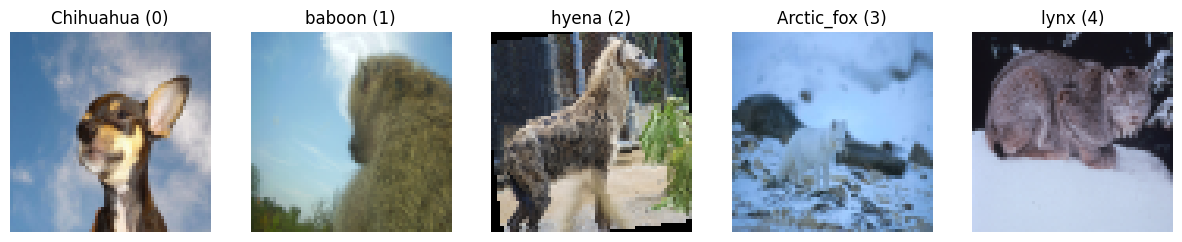

In [ ]:
# Load and display sample images
if __name__ == '__main__':
    try:
        train_data, train_labels = load_pth(train_path_1)
        print('Displaying images for all classes:')
        # Filter labels before displaying
        mask = np.isin(train_labels, list(label_mapping_1.keys()))
        filtered_images = train_data[mask]
        filtered_labels = np.array([label_mapping_1[int(label)] for label in train_labels[mask]])
        display_images(filtered_images, filtered_labels, class_names_1)
    except Exception as e:
        print(f"Error displaying images: {str(e)}")

In [ ]:
# Train Model 1
model1 = CNNModel(train_path_1, test_path_1, label_mapping_1, class_names_1, input_shape, cnn_architecture_1, epochs, batch_size)


In [ ]:
X_train1, y_train1, X_test1, y_test1 = model1.load_data()
print("Pixel range:", X_train1.min(), X_train1.max())

Pixel range: 0.0 1.0


In [ ]:
# For Model 1
X_train1, y_train1 = shuffle(X_train1, y_train1, random_state=42)

In [ ]:

print("\nData Shapes:")
print(f"Train: {X_train1.shape}, {y_train1.shape}")
print(f"Test: {X_test1.shape}, {y_test1.shape}")


Data Shapes:
Train: (5697, 64, 64, 3), (5697,)
Test: (450, 64, 64, 3), (450,)


In [ ]:
model1.build_model()

Model 1 Total Parameters: 835968


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_8 (SeparableConv2D) │ (None, 64, 64, 96)          │             411 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 64, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_9 (SeparableConv2D) │ (None, 64, 64, 96)          │          10,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 64, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32, 32, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_10                  │ (None, 32, 32, 192)         │          19,488 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 32, 32, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_11                  │ (None, 32, 32, 192)         │          38,784 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32, 32, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 384)         │         663,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 384)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 835,968 (3.19 MB)

 Trainable params: 834,304 (3.18 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
model1.train(X_train1, y_train1)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.3687 - loss: 1.5646 - val_accuracy: 0.1737 - val_loss: 2.2018
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.4868 - loss: 1.2748 - val_accuracy: 0.1825 - val_loss: 2.8259
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5203 - loss: 1.1781 - val_accuracy: 0.1737 - val_loss: 2.6435
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5382 - loss: 1.1845 - val_accuracy: 0.1825 - val_loss: 4.1758
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6044 - loss: 1.0476 - val_accuracy: 0.1895 - val_loss: 4.1505
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6338 - loss: 0.9729 - val_accuracy: 0.2368 - val_loss: 5.7956
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6655 - loss: 0.9186 - val_accuracy: 0.1737 - val_loss: 7.8381
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6714 - loss: 0.8779 - val_accuracy: 0.2193 -

In [ ]:
model1.evaluate(X_test1, y_test1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7456 - loss: 0.7314


[0.7695476412773132, 0.7355555295944214]

In [ ]:
model1.classification_report(X_test1, y_test1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
              precision    recall  f1-score   support

   Chihuahua       0.93      0.56      0.69        90
      baboon       0.74      0.58      0.65        90
       hyena       0.67      0.91      0.77        90
  Arctic_fox       0.73      0.87      0.79        90
        lynx       0.72      0.77      0.74        90

    accuracy                           0.74       450
   macro avg       0.76      0.74      0.73       450
weighted avg       0.76      0.74      0.73       450



array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 4, 4,
       4, 3, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 0, 4, 4, 4, 4, 2, 2, 1, 1, 3, 4, 1, 1, 2, 1,
       1, 1, 4, 4, 2, 1, 1, 2, 1, 3, 4, 1, 2, 2, 3, 4, 2, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 3, 3, 1, 1, 1, 2, 0, 0, 0, 0, 0, 3, 0, 3, 3, 1, 3,
       0, 4, 0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 2, 0, 4, 0, 4, 3, 0, 3, 0, 0,
       0, 0, 4, 0, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       2, 3, 3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 4, 3, 4, 1, 0, 3, 0, 3, 4, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 4, 0, 0, 3, 0, 2, 0, 4, 0, 4, 4, 0, 4, 0,
       3, 0, 0, 0, 2, 4, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

   Chihuahua       0.93      0.56      0.69        90
      baboon       0.74      0.58      0.65        90
       hyena       0.67      0.91      0.77        90
  Arctic_fox       0.73      0.87      0.79        90
        lynx       0.72      0.77      0.74        90

    accuracy                           0.74       450
   macro avg       0.76      0.74      0.73       450
weighted avg       0.76      0.74      0.73       450



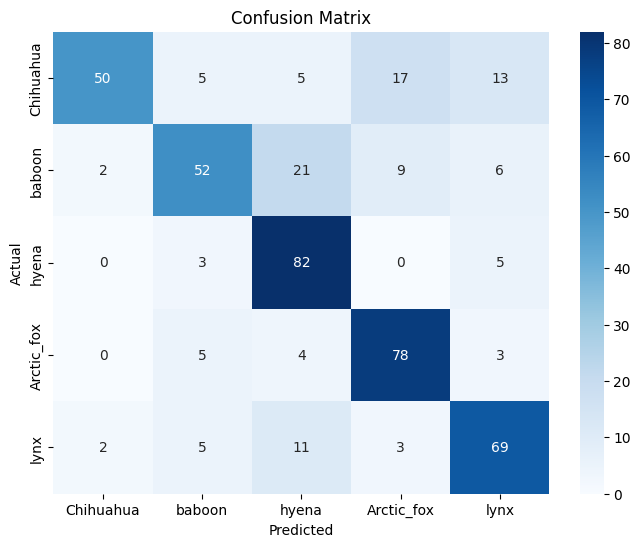

In [ ]:
model1.plot_confusion_matrix(X_test1, y_test1)

In [ ]:
model1.save("model1")

# **Model 2:**

In [ ]:
# Model 2
train_path_2 = "/content/drive/MyDrive/Merged_Datasets/fusion_model2_train.pth"
test_path_2 = "/content/drive/MyDrive/Merged_Datasets/fusion_model2_test.pth"
label_mapping_2 = {
    24: 0,   # African Elephant
    34: 1,   # Hyena
    80: 2,   # Zebra
    135: 3,  # Patas
    202: 4   # African Hunting Dog
}
class_names_2 = ['African Elephant', 'Hyena', 'Zebra', 'Patas', 'African Hunting Dog']

In [ ]:
# Train Model 2
model2 = CNNModel(train_path_2, test_path_2, label_mapping_2, class_names_2, input_shape, cnn_architecture_2, epochs, batch_size)

In [ ]:
X_train2, y_train2, X_test2, y_test2 = model2.load_data()
print("Pixel range:", X_train2.min(), X_train2.max())

Pixel range: 0.0 1.0


In [ ]:
# For Model 2
X_train2, y_train2 = shuffle(X_train2, y_train2, random_state=42)
X_test2, y_test2 = shuffle(X_test2, y_test2, random_state=42)


In [ ]:
print("\nData Shapes:")
print(f"Train: {X_train2.shape}, {y_train2.shape}")
print(f"Test: {X_test2.shape}, {y_test2.shape}")


Data Shapes:
Train: (5722, 64, 64, 3), (5722,)
Test: (450, 64, 64, 3), (450,)


In [ ]:
model2.build_model()

Model 2 Total Parameters: 397408


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_16                  │ (None, 64, 64, 64)          │             283 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_17                  │ (None, 64, 64, 64)          │           4,736 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_18                  │ (None, 32, 32, 128)         │           8,896 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_19                  │ (None, 32, 32, 128)         │          17,664 │
│ (SeparableConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 397,408 (1.52 MB)

 Trainable params: 395,616 (1.51 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
model2.train(X_train2, y_train2)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.3270 - loss: 1.7386 - val_accuracy: 0.1763 - val_loss: 1.8719
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4789 - loss: 1.2935 - val_accuracy: 0.1763 - val_loss: 2.1020
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5484 - loss: 1.1531 - val_accuracy: 0.1763 - val_loss: 3.3759
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5820 - loss: 1.0468 - val_accuracy: 0.1763 - val_loss: 4.7692
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6232 - loss: 0.9473 - val_accuracy: 0.1763 - val_loss: 6.0604
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6849 - loss: 0.8402 - val_accuracy: 0.1763 - val_loss: 4.4249
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7020 - loss: 0.7823 - val_accuracy: 0.1763 - val_loss: 4.9649
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.7331 - loss: 0.7077 - val_accuracy: 0.2583 

In [ ]:
model2.evaluate(X_test2, y_test2)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7004 - loss: 1.1719


[1.2624777555465698, 0.695555567741394]

In [ ]:
model2.classification_report(X_test2, y_test2)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
                     precision    recall  f1-score   support

   African Elephant       1.00      0.40      0.57        90
              Hyena       0.53      0.87      0.66        90
              Zebra       0.99      0.74      0.85        90
              Patas       0.72      0.51      0.60        90
African Hunting Dog       0.64      0.96      0.77        90

           accuracy                           0.70       450
          macro avg       0.77      0.70      0.69       450
       weighted avg       0.77      0.70      0.69       450



array([2, 2, 4, 1, 2, 4, 1, 2, 4, 1, 2, 3, 1, 2, 0, 2, 4, 1, 1, 1, 3, 3,
       2, 1, 4, 2, 4, 3, 2, 4, 4, 1, 0, 4, 1, 1, 1, 2, 3, 2, 4, 2, 1, 4,
       1, 1, 4, 3, 1, 3, 1, 4, 1, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 3, 1, 1,
       2, 1, 3, 4, 1, 1, 1, 4, 2, 4, 1, 4, 1, 1, 2, 1, 4, 1, 4, 1, 1, 0,
       1, 3, 1, 1, 3, 1, 4, 1, 4, 4, 2, 1, 1, 4, 1, 1, 4, 4, 1, 4, 4, 1,
       3, 1, 0, 4, 3, 4, 2, 2, 4, 1, 1, 3, 3, 1, 4, 4, 3, 4, 1, 4, 1, 3,
       3, 1, 1, 2, 4, 4, 2, 4, 4, 4, 2, 1, 1, 2, 0, 4, 4, 1, 2, 0, 4, 4,
       0, 1, 1, 2, 2, 3, 4, 4, 4, 1, 2, 1, 1, 1, 3, 4, 1, 1, 4, 0, 2, 1,
       1, 1, 2, 2, 0, 3, 2, 3, 4, 4, 0, 1, 1, 1, 4, 2, 4, 1, 1, 4, 4, 4,
       1, 3, 4, 2, 1, 1, 1, 1, 4, 1, 4, 4, 1, 4, 2, 1, 4, 1, 1, 1, 2, 0,
       1, 2, 0, 3, 4, 4, 3, 3, 1, 1, 2, 4, 0, 4, 1, 3, 4, 3, 1, 1, 4, 3,
       2, 2, 2, 3, 1, 4, 4, 4, 3, 4, 2, 1, 2, 2, 1, 1, 1, 3, 0, 4, 1, 3,
       1, 3, 2, 0, 4, 3, 2, 2, 0, 1, 4, 4, 3, 4, 2, 0, 2, 2, 4, 4, 1, 4,
       0, 1, 2, 4, 3, 4, 4, 0, 2, 3, 4, 1, 0, 2, 1,

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
                     precision    recall  f1-score   support

   African Elephant       1.00      0.40      0.57        90
              Hyena       0.53      0.87      0.66        90
              Zebra       0.99      0.74      0.85        90
              Patas       0.72      0.51      0.60        90
African Hunting Dog       0.64      0.96      0.77        90

           accuracy                           0.70       450
          macro avg       0.77      0.70      0.69       450
       weighted avg       0.77      0.70      0.69       450



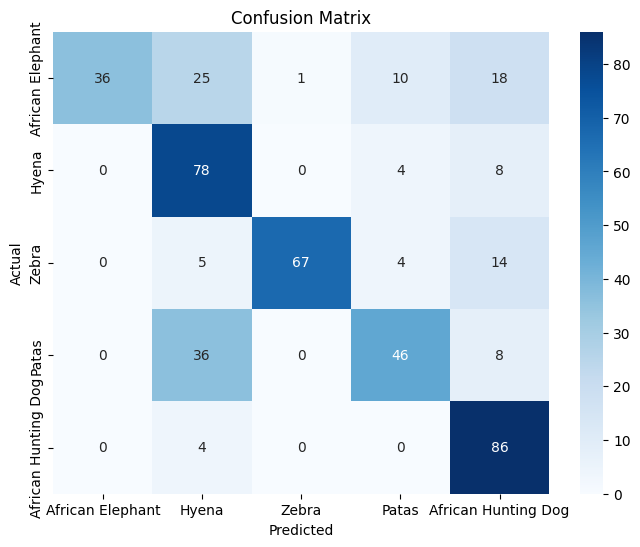

In [ ]:
model2.plot_confusion_matrix(X_test2, y_test2)

In [ ]:
model2.save("model2")

# **Model 3:**

In [ ]:
train_path_3 = "/content/drive/MyDrive/TaskB_data/train_dataB_model_3.pth"
test_path_3 = "/content/drive/MyDrive/TaskB_data/val_dataB_model_3.pth"

# train_dataB_model_3
# val_dataB_model_3

label_mapping_3 = {
    124: 0,  # Collie -> 0
    202: 1   # African Hunting Dog -> 1
}

Classes3 = ["Collie", "African Hunting Dog"]


In [ ]:
# Function to filter out unwanted classes
def filter_classes(X, y, label_mapping):
    """Filter out data and labels for classes not in the label mapping."""
    # Create a list of valid labels (keys in the label mapping)
    valid_labels = list(label_mapping.keys())

    # Filter data and labels
    mask = np.isin(y, valid_labels)
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Map the labels to the new label mapping
    y_filtered = np.array([label_mapping[int(label)] for label in y_filtered])

    return X_filtered, y_filtered

In [ ]:
# Load and preprocess data for Model 3
def load_data_model_3(train_path, test_path, label_mapping):
    """Load and preprocess data for Model 3, filtering out unwanted classes."""
    # Load raw data
    train_data = torch.load(train_path, weights_only=True)
    test_data = torch.load(test_path, weights_only=True)

    # Extract data and labels
    X_train = train_data['data'].numpy()
    y_train = train_data['labels'].numpy()
    X_test = test_data['data'].numpy()
    y_test = test_data['labels'].numpy()

    # Filter out unwanted classes
    X_train, y_train = filter_classes(X_train, y_train, label_mapping)
    X_test, y_test = filter_classes(X_test, y_test, label_mapping)

    # Normalize data
    X_train = X_train / 255.0
    X_test = X_test / 255.0

    return X_train, y_train, X_test, y_test

In [ ]:
# Load and preprocess data for Model 3
X_train3, y_train3, X_test3, y_test3 = load_data_model_3(train_path_3, test_path_3, label_mapping_3)

# Print shapes of the data
print(f"Shape of X_train3: {X_train3.shape}")
print(f"Shape of y_train3: {y_train3.shape}")
print(f"Shape of X_test3: {X_test3.shape}")
print(f"Shape of y_test3: {y_test3.shape}")


Shape of X_train3: (1273, 64, 64, 3)
Shape of y_train3: (1273,)
Shape of X_test3: (100, 64, 64, 3)
Shape of y_test3: (100,)


In [ ]:
# Train Model 3
model3 = CNNModel(train_path_3, test_path_3, label_mapping_3, Classes3, input_shape, cnn_architecture_3, epochs)


In [ ]:

# Build the model
model3.build_model()

Model 3 Total Parameters: 6498946


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,498,946 (24.79 MB)

 Trainable params: 6,498,946 (24.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model3.train(X_train3, y_train3)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.5041 - loss: 1.6470 - val_accuracy: 0.0000e+00 - val_loss: 0.7009
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5929 - loss: 0.6729 - val_accuracy: 0.0000e+00 - val_loss: 0.9725
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6691 - loss: 0.6116 - val_accuracy: 0.3438 - val_loss: 0.8952
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7518 - loss: 0.5150 - val_accuracy: 0.3047 - val_loss: 1.0285
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7591 - loss: 0.4857 - val_accuracy: 0.4453 - val_loss: 0.8397
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8444 - loss: 0.3649 - val_accuracy: 0.8672 - val_loss: 0.3581
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8633 - loss: 0.3304 - val_accuracy: 0.8203 - val_loss: 0.4308
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8798 - loss: 0.2693 - val_accuracy: 0.

In [ ]:
# Evaluate the model
model3.evaluate(X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8610 - loss: 0.3294


[0.4156455993652344, 0.8399999737739563]

In [ ]:
# Generate classification report
model3.classification_report(X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
                     precision    recall  f1-score   support

             Collie       0.90      0.76      0.83        50
African Hunting Dog       0.79      0.92      0.85        50

           accuracy                           0.84       100
          macro avg       0.85      0.84      0.84       100
       weighted avg       0.85      0.84      0.84       100



array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
                     precision    recall  f1-score   support

             Collie       0.90      0.76      0.83        50
African Hunting Dog       0.79      0.92      0.85        50

           accuracy                           0.84       100
          macro avg       0.85      0.84      0.84       100
       weighted avg       0.85      0.84      0.84       100



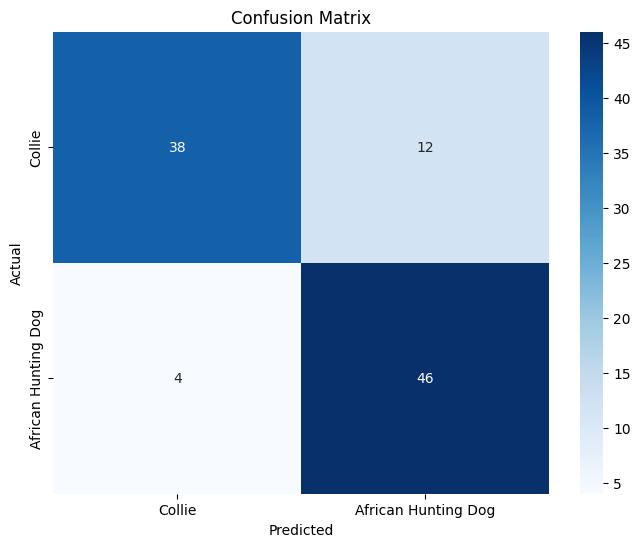

In [ ]:
# Plot confusion matrix
model3.plot_confusion_matrix(X_test3, y_test3)

In [ ]:
# Save the model
model3.save("model3")

# **Feature Level Fusion**

### **For Model 1, 2 and 3:**

In [ ]:
# Function to extract features from the penultimate layer
def extract_features(cnn_model, X):
    # Ensure the model is built by passing a dummy input through the call method

    feature_extractor = Model(inputs=cnn_model.model.input, outputs=cnn_model.model.layers[-2].output)
    return feature_extractor.predict(X.astype(np.float32))


# Extract features for training data
features_train1 = extract_features(model1, X_train1)
features_train2 = extract_features(model2, X_train2)
features_train3 = extract_features(model3, X_train3)

# Extract features for testing data
features_test1 = extract_features(model1, X_test1)
features_test2 = extract_features(model2, X_test2)
features_test3 = extract_features(model3, X_test3)


print(type(features_train1))
print(features_train1.shape)
print(features_train2.shape)
print(features_test1.shape)
print(features_test2.shape)
print(features_test3.shape)

# Feature-level fusion: Concatenation
fused_train_features = np.concatenate((features_train1, features_train2,features_train3), axis=0)
fused_test_features = np.concatenate((features_test1, features_test2,features_test3), axis=0)

print("fused_train_features",len(features_train1),len(features_train2),len(features_train3),"==",len(fused_train_features))
print("fused_test_features",len(features_test1),len(features_test2),len(features_test3),"==",len(fused_test_features))
# print("fuesed_test_feature")

# Define labels for fused model

y_train_fused = np.concatenate((y_train1, y_train2,y_train3), axis=0)
y_test_fused = np.concatenate((y_test1, y_test2,y_test3), axis=0)

print("y_train_fused",len(y_train1),len(y_train2),len(y_train3),"==",len(y_train_fused))
print("y_test_fused",len(y_test1),len(y_test2),len(y_test3),"==",len(y_test_fused))

# Convert labels to categorical
num_classes = len(class_names_1) + len(class_names_2) + len(Classes3)

combined_classes_list = class_names_1 + class_names_2 + Classes3
print(combined_classes_list)
fused_train_features.shape

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
<class 'numpy.ndarray'>
(5697, 256)
(5722, 256)
(450, 256)
(450, 256)
(100, 256)
fused_train_features 5697 5722 1273 == 12692
fused_test_features 450 450 100 == 1000
y_train_fused 5697 5722 1273 == 12692
y_test_fused 450 450 100 == 1000
['Chihuahua', 'baboon', 'hyena', 'Arctic_fox', 'lynx', 'African Elephant', 'Hyena', 'Zebra', 'Patas', 'African Hunting Dog', 'Collie', 'African Hunting Dog']


(12692, 256)

In [ ]:

input_layer = Input(shape=(fused_train_features.shape[1],))

# Enhanced architecture with batch normalization and regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(16, activation='relu')(x)

output_layer = Dense(num_classes, activation='softmax')(x)

fusion_model = Model(inputs=input_layer, outputs=output_layer)

# Improved compilation with learning rate tuning
optimizer = Adam(learning_rate=0.0005)
fusion_model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
fusion_model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,860 (175.23 KB)

 Trainable params: 44,412 (173.48 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Train fusion model
fusion_model.fit(fused_train_features, y_train_fused, epochs=15, validation_data=(fused_test_features, y_test_fused))

Epoch 1/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4506 - loss: 2.0003 - val_accuracy: 0.7890 - val_loss: 0.9394
Epoch 2/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8437 - loss: 0.8262 - val_accuracy: 0.7990 - val_loss: 0.8848
Epoch 3/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8779 - loss: 0.6699 - val_accuracy: 0.8150 - val_loss: 0.8604
Epoch 4/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8894 - loss: 0.6101 - val_accuracy: 0.8160 - val_loss: 0.8517
Epoch 5/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8931 - loss: 0.5818 - val_accuracy: 0.8130 - val_loss: 0.8223
Epoch 6/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9038 - loss: 0.5393 - val_accuracy: 0.8090 - val_loss: 0.8243
Epoch 7/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9038 - loss: 0.5211 - val_accuracy: 0.7990 - val_loss: 0.8144
Epoch 8/15
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9067 - loss: 0.4972 - val_accuracy: 

In [ ]:
# Evaluate fusion model
fusion_model.evaluate(fused_test_features, y_test_fused)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7723 - loss: 0.8121


[0.7779212594032288, 0.7940000295639038]

In [ ]:
# Save the fused model
fusion_model.save("fusion_model.h5")